## Analysis of Spotify data

In this notebook, we are analysing the basic features of different Spotify songs. The goal being to cluster and them to define the metrics that can be used to recognize the type of a song as well as finding similar song. 

In [34]:
from sklearn.preprocessing import StandardScaler

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

In [6]:
cid ="47e61e82d3044694b1735d8d566a159a" 
secret = "63c23dcc717745f389f658884059fc9c"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [7]:
start = timeit.default_timer()
artist_name, track_name, popularity, track_id = [], [], [], []

for i in range(0,10000,50):
    track_results = sp.search(q='year:2018', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
      
stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 191.66811651282052


In [8]:
print('artist: ', len(artist_name))
print('\n track', len(track_name))
print('\n popularity', len(popularity))
print('\n track_id', len(track_id))

artist:  10000

 track 10000

 popularity 10000

 track_id 10000


In [9]:
dat = pd.DataFrame({'artist':artist_name,'track':track_name,'track_id':track_id,'popularity':popularity})

In [10]:
dat.head()

,artist,track,track_id,popularity
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,98
1,Los Unidades,E-Lo (feat. Jozzy),3eydp9rHJAskzOevEBK267,68
2,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,98
3,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,94
4,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97


In [11]:
dat.describe()

,popularity
count,10000.000000
mean,59.775000
std,8.506633
min,45.000000
25%,53.000000
50%,58.000000
75%,64.000000
max,98.000000


### Number of duplicate

In [12]:
grouped = dat.groupby(['artist','track'], as_index=True).size()
grouped[grouped > 1].count()

2397

In [13]:
dat.drop_duplicates(subset=['artist','track'], inplace=True)

In [14]:
dat.shape

(6958, 4)

In [15]:
start = timeit.default_timer()
rows = []
batchs = 100
# counter for None results
None_counter = 0

for i in range(0,len(dat['track_id']), batchs):
    batch = dat['track_id'][i:i+batchs]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

Number of tracks where no audio features were available: 1
Time to run this code (in seconds): 14.623249641025637


In [16]:
aud = pd.DataFrame.from_dict(rows,orient='columns')

In [17]:
aud.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.556,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,3KkXRkHbMCARz0aVfEt68P,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.913
1,0.469,https://api.spotify.com/v1/audio-analysis/3eyd...,0.698,214720,0.797,3eydp9rHJAskzOevEBK267,0.001180,3,0.1520,-5.125,0,0.0615,101.969,4,https://api.spotify.com/v1/tracks/3eydp9rHJAsk...,audio_features,spotify:track:3eydp9rHJAskzOevEBK267,0.530
2,0.163,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,6MWtB6iiXyIwun0YzU6DFP,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
3,0.259,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,2IRZnDFmlqMuOrYOLnZZyc,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,audio_features,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,0.544
4,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,5p7ujcrUXASCNwRaWNHR1C,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533


In [18]:
aud.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6957.000000,6957.000000,6.957000e+03,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000
mean,0.289448,0.645993,1.997040e+05,0.590962,0.099679,5.266063,0.175151,-7.631607,0.599828,0.125064,120.867503,3.926549,0.444842
std,0.301331,0.164421,5.538809e+04,0.217748,0.262109,3.619569,0.135277,4.384584,0.489968,0.121590,30.171677,0.384330,0.228845
min,0.000004,0.000000,3.113600e+04,0.000900,0.000000,0.000000,0.014900,-38.905000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040400,0.544000,1.705390e+05,0.466000,0.000000,2.000000,0.098400,-8.810000,0.000000,0.041100,96.002000,4.000000,0.264000
50%,0.165000,0.669000,1.980000e+05,0.611000,0.000002,5.000000,0.119000,-6.560000,1.000000,0.067500,120.043000,4.000000,0.431000
75%,0.476000,0.765000,2.257320e+05,0.752000,0.000901,8.000000,0.203000,-4.995000,1.000000,0.174000,142.086000,4.000000,0.612000
max,0.996000,0.985000,1.355938e+06,0.996000,0.993000,11.000000,0.979000,0.598000,1.000000,0.966000,216.115000,5.000000,0.980000


In [19]:
dat = dat.rename(columns={'track_id':'id'})

In [20]:
fdt = pd.merge(dat, aud, on='id', how='inner')

In [21]:
fdt.head()

,artist,track,id,popularity,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,98,0.556,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,0.000000,...,0.0703,-5.574,1,0.0466,89.911,4,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.913
1,Los Unidades,E-Lo (feat. Jozzy),3eydp9rHJAskzOevEBK267,68,0.469,https://api.spotify.com/v1/audio-analysis/3eyd...,0.698,214720,0.797,0.001180,...,0.1520,-5.125,0,0.0615,101.969,4,https://api.spotify.com/v1/tracks/3eydp9rHJAsk...,audio_features,spotify:track:3eydp9rHJAskzOevEBK267,0.530
2,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,98,0.163,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,0.000002,...,0.1010,-7.399,0,0.1780,99.947,4,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,audio_features,spotify:track:6MWtB6iiXyIwun0YzU6DFP,0.385
3,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,94,0.259,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,0.000000,...,0.2520,-6.365,0,0.0905,86.003,4,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,audio_features,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,0.544
4,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,0.000009,...,0.0936,-7.050,1,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533


In [22]:
fdt.shape

(6957, 21)

In [23]:
fdt.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6957.000000,6957.000000,6957.000000,6.957000e+03,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000
mean,60.392842,0.289448,0.645993,1.997040e+05,0.590962,0.099679,5.266063,0.175151,-7.631607,0.599828,0.125064,120.867503,3.926549,0.444842
std,9.034766,0.301331,0.164421,5.538809e+04,0.217748,0.262109,3.619569,0.135277,4.384584,0.489968,0.121590,30.171677,0.384330,0.228845
min,45.000000,0.000004,0.000000,3.113600e+04,0.000900,0.000000,0.000000,0.014900,-38.905000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.040400,0.544000,1.705390e+05,0.466000,0.000000,2.000000,0.098400,-8.810000,0.000000,0.041100,96.002000,4.000000,0.264000
50%,59.000000,0.165000,0.669000,1.980000e+05,0.611000,0.000002,5.000000,0.119000,-6.560000,1.000000,0.067500,120.043000,4.000000,0.431000
75%,66.000000,0.476000,0.765000,2.257320e+05,0.752000,0.000901,8.000000,0.203000,-4.995000,1.000000,0.174000,142.086000,4.000000,0.612000
max,98.000000,0.996000,0.985000,1.355938e+06,0.996000,0.993000,11.000000,0.979000,0.598000,1.000000,0.966000,216.115000,5.000000,0.980000


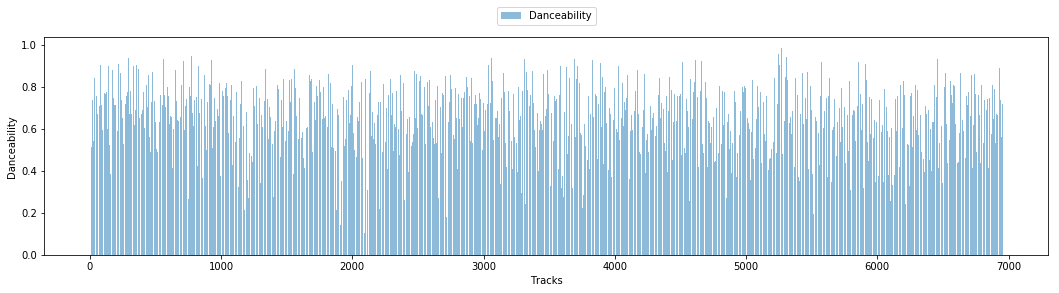

In [24]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(fdt.shape[0]), fdt['danceability'], alpha=0.5, label='Danceability')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Danceability')
plt.xlabel('Tracks')
plt.show()

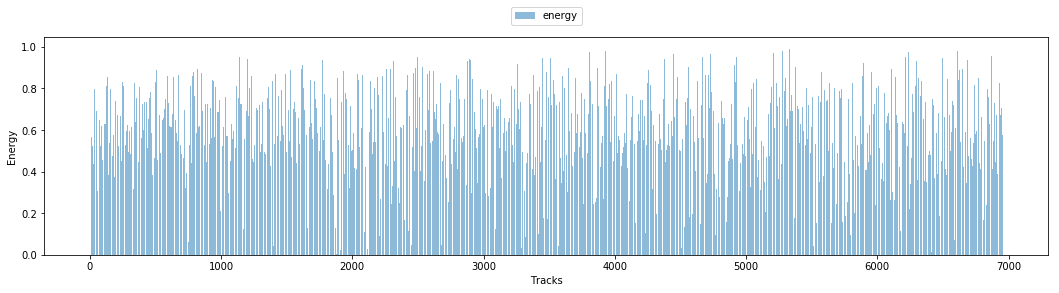

In [25]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(fdt.shape[0]), fdt['energy'], alpha=0.5, label='energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

In [26]:
fdt.columns

Index(['artist', 'track', 'id', 'popularity', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

In [27]:
fda = fdt[['popularity', 'acousticness', 'analysis_url',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence']]

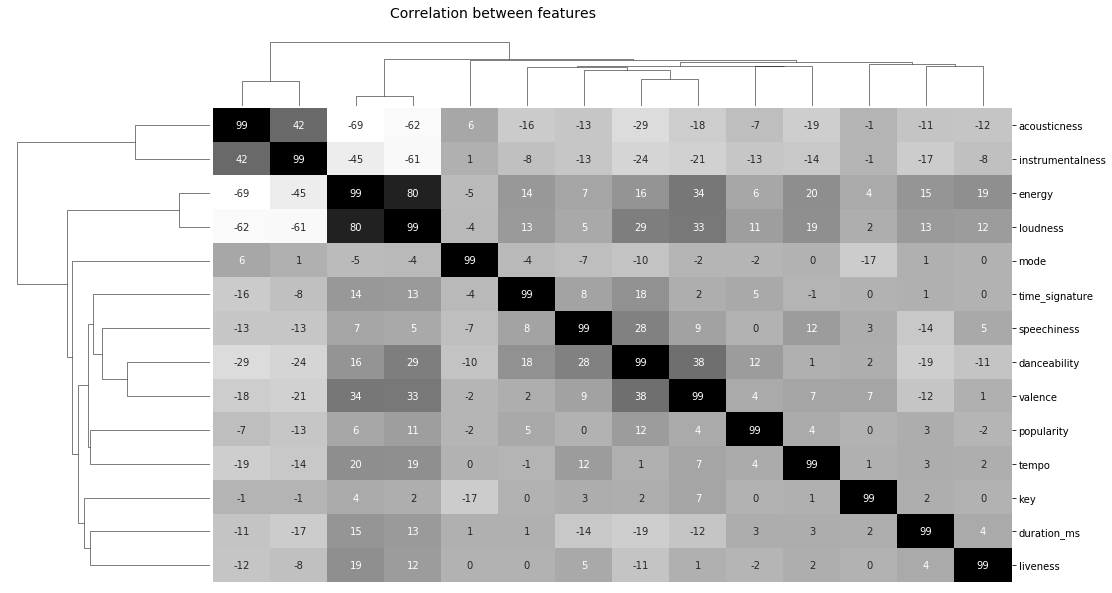

In [28]:
cor = fda.corr()
cor = pd.DataFrame(np.round(cor.values*100).astype('int').clip(max=99), columns=cor.columns, index=cor.index)
cmp = sns.clustermap(cor, cmap='Greys', annot=True, figsize=(18,10))
_ = cmp.fig.suptitle('Correlation between features', y=0.925, size=14) 
_ = cmp.cax.set_visible(False)
_ = cmp.ax_heatmap.set_xticks([])

In [29]:
fda.head()

,popularity,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,98,0.556,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,68,0.469,https://api.spotify.com/v1/audio-analysis/3eyd...,0.698,214720,0.797,0.001180,3,0.1520,-5.125,0,0.0615,101.969,4,0.530
2,98,0.163,https://api.spotify.com/v1/audio-analysis/6MWt...,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385
3,94,0.259,https://api.spotify.com/v1/audio-analysis/2IRZ...,0.889,180522,0.496,0.000000,4,0.2520,-6.365,0,0.0905,86.003,4,0.544
4,97,0.297,https://api.spotify.com/v1/audio-analysis/5p7u...,0.752,201661,0.488,0.000009,6,0.0936,-7.050,1,0.0705,136.041,4,0.533


In [30]:
fda.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,6957.000000,6957.000000,6957.000000,6.957000e+03,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000
mean,60.392842,0.289448,0.645993,1.997040e+05,0.590962,0.099679,5.266063,0.175151,-7.631607,0.599828,0.125064,120.867503,3.926549,0.444842
std,9.034766,0.301331,0.164421,5.538809e+04,0.217748,0.262109,3.619569,0.135277,4.384584,0.489968,0.121590,30.171677,0.384330,0.228845
min,45.000000,0.000004,0.000000,3.113600e+04,0.000900,0.000000,0.000000,0.014900,-38.905000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.040400,0.544000,1.705390e+05,0.466000,0.000000,2.000000,0.098400,-8.810000,0.000000,0.041100,96.002000,4.000000,0.264000
50%,59.000000,0.165000,0.669000,1.980000e+05,0.611000,0.000002,5.000000,0.119000,-6.560000,1.000000,0.067500,120.043000,4.000000,0.431000
75%,66.000000,0.476000,0.765000,2.257320e+05,0.752000,0.000901,8.000000,0.203000,-4.995000,1.000000,0.174000,142.086000,4.000000,0.612000
max,98.000000,0.996000,0.985000,1.355938e+06,0.996000,0.993000,11.000000,0.979000,0.598000,1.000000,0.966000,216.115000,5.000000,0.980000


In [32]:
fdam = fda[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness','key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']]

In [35]:
scaler = StandardScaler(with_std=False)
mod = scaler.fit_transform(fdam.values)

In [37]:
fda.shape

(6957, 15)

From this visualization, we can see that two very different small clusters appear: {acousticness - instrumentalness} and {energy - loudness}

In [40]:
k = 5
n = fda.shape[0]
kmeans = KMeans(n_clusters=k, init='random')
kmeans.fit(mod)
clusters = []
for j in range(0,k):
    clusters.append([])
for i in range(0,n):
    clusters[kmeans.labels_[i]].append(i)
#
# Print out clusters size
#
for j in range(0,k):
    print('Cluster {}'.format(j+1),'\n', len(clusters[j]), '\n\n')

Cluster 1 
 730 


Cluster 2 
 58 


Cluster 3 
 884 


Cluster 4 
 2591 


Cluster 5 
 2694 




In [57]:
Cluster1 = fda.iloc[clusters[0],:]
Cluster2 = fda.iloc[clusters[1],:]
Cluster3 = fda.iloc[clusters[2],:]
Cluster4 = fda.iloc[clusters[3],:]
Cluster5 = fda.iloc[clusters[4],:]

In [58]:
Cluster1.shape

(730, 15)

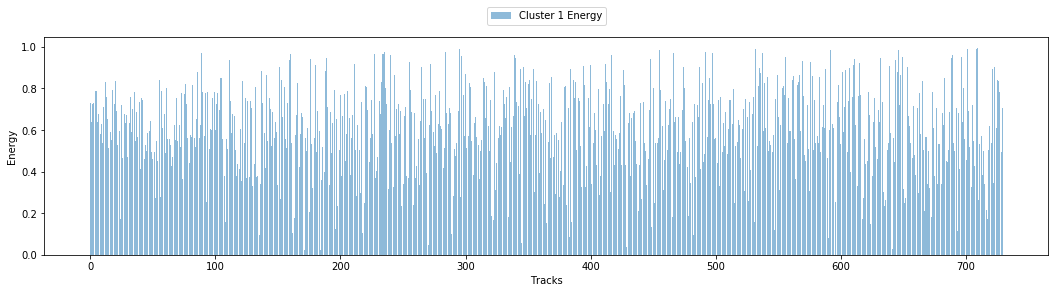

In [61]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(Cluster1.shape[0]), Cluster1['energy'], alpha=0.5, label='Cluster 1 Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

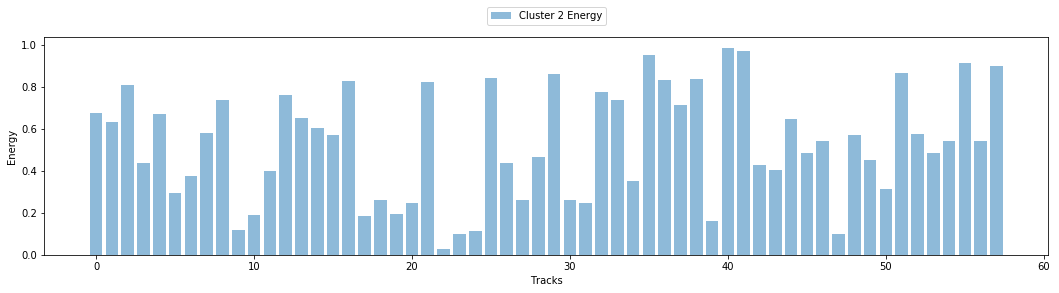

In [62]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(Cluster2.shape[0]), Cluster2['energy'], alpha=0.5, label='Cluster 2 Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

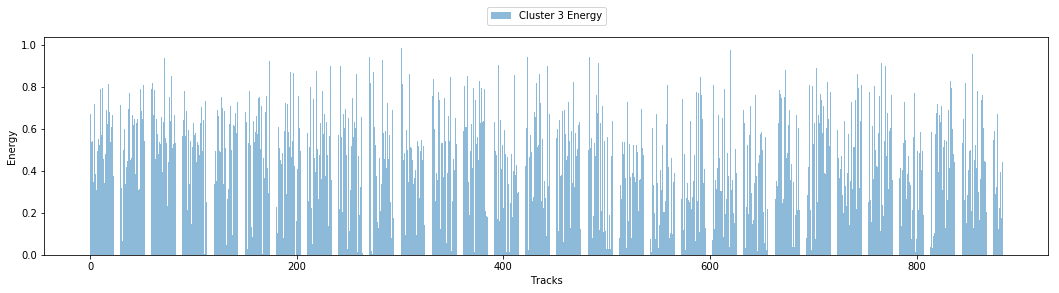

In [63]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(Cluster3.shape[0]), Cluster3['energy'], alpha=0.5, label='Cluster 3 Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

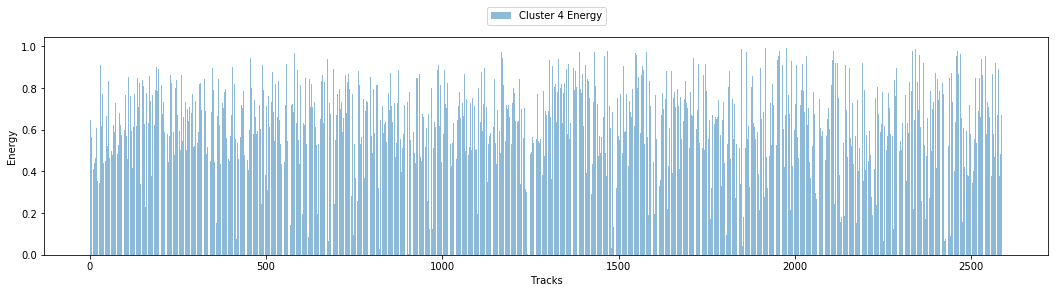

In [64]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(Cluster4.shape[0]), Cluster4['energy'], alpha=0.5, label='Cluster 4 Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

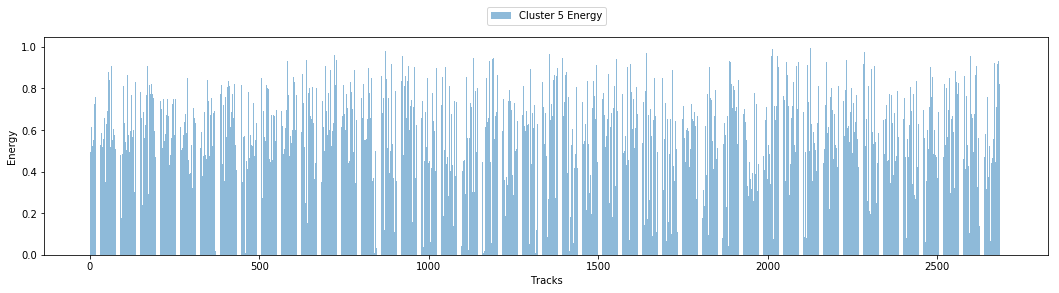

In [65]:
plt.figure(figsize=(18,4))
plt.bar(np.arange(Cluster5.shape[0]), Cluster5['energy'], alpha=0.5, label='Cluster 5 Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Tracks')
plt.show()

In [69]:
print('Mean energy of cluster1 :', Cluster1['energy'].mean(),
      '\n\n Mean energy of cluster 2: ', Cluster2['energy'].mean(),
      '\n\n Mean energy of cluster 3: ', Cluster3['energy'].mean(),
      '\n\n Mean energy of cluster 4: ', Cluster4['energy'].mean(),
      '\n\n Mean energy of cluster 5: ', Cluster5['energy'].mean(),)

Mean energy of cluster1 : 0.6002944794520554 

 Mean energy of cluster 2:  0.5293293103448274 

 Mean energy of cluster 3:  0.4637927714932123 

 Mean energy of cluster 4:  0.6235593245851019 

 Mean energy of cluster 5:  0.6001377319970301


### Energy

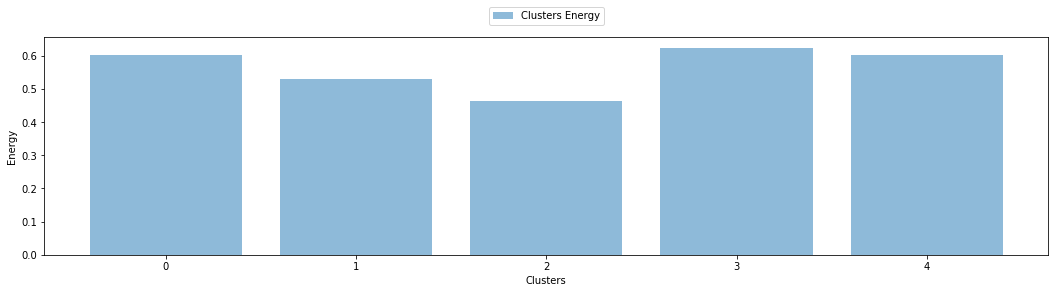

In [70]:
plt.figure(figsize=(18,4))
y = [Cluster1['energy'].mean(), Cluster2['energy'].mean(), Cluster3['energy'].mean(), Cluster4['energy'].mean(), Cluster5['energy'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters Energy')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Energy')
plt.xlabel('Clusters')
plt.show()

### Acousticness

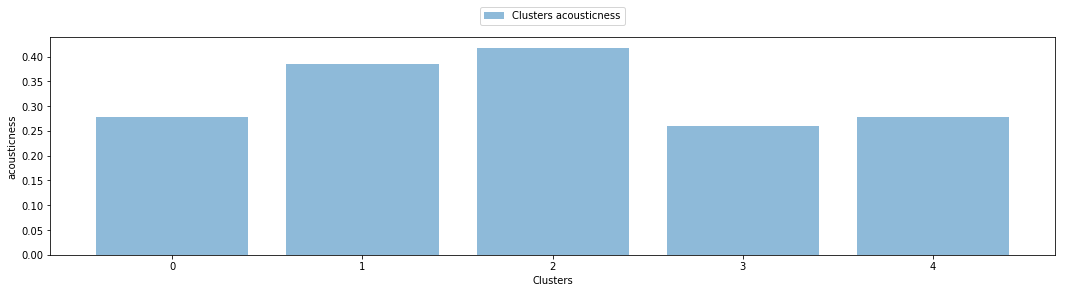

In [71]:
plt.figure(figsize=(18,4))
y = [Cluster1['acousticness'].mean(), Cluster2['acousticness'].mean(), Cluster3['acousticness'].mean(), Cluster4['acousticness'].mean(), Cluster5['acousticness'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters acousticness')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('acousticness')
plt.xlabel('Clusters')
plt.show()

### Danceability

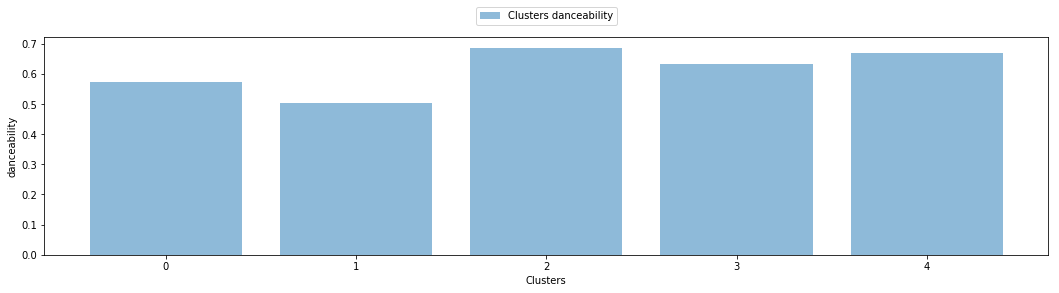

In [72]:
plt.figure(figsize=(18,4))
y = [Cluster1['danceability'].mean(), Cluster2['danceability'].mean(), Cluster3['danceability'].mean(), Cluster4['danceability'].mean(), Cluster5['danceability'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters danceability')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('danceability')
plt.xlabel('Clusters')
plt.show()

### Duration

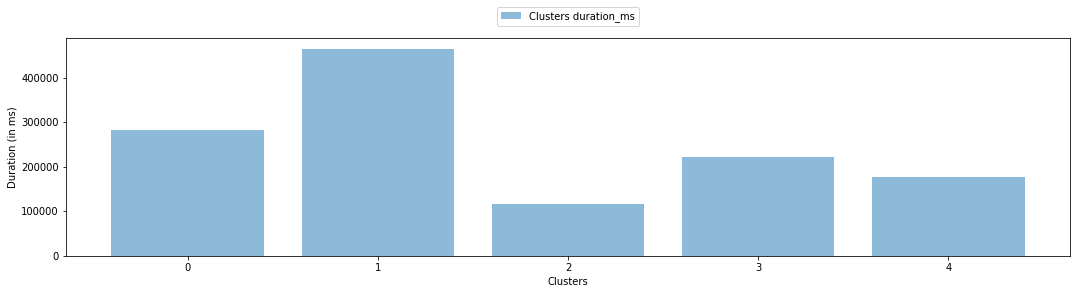

In [73]:
plt.figure(figsize=(18,4))
y = [Cluster1['duration_ms'].mean(), Cluster2['duration_ms'].mean(), Cluster3['duration_ms'].mean(), Cluster4['duration_ms'].mean(), Cluster5['duration_ms'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters duration_ms')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('Duration (in ms)')
plt.xlabel('Clusters')
plt.show()

### Instrumentalness

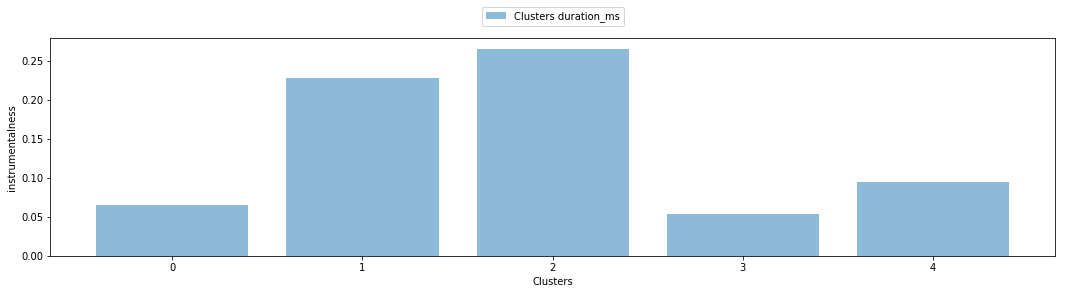

In [74]:
plt.figure(figsize=(18,4))
y = [Cluster1['instrumentalness'].mean(), Cluster2['instrumentalness'].mean(), Cluster3['instrumentalness'].mean(), Cluster4['instrumentalness'].mean(), Cluster5['instrumentalness'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters duration_ms')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('instrumentalness')
plt.xlabel('Clusters')
plt.show()

### Speechiness

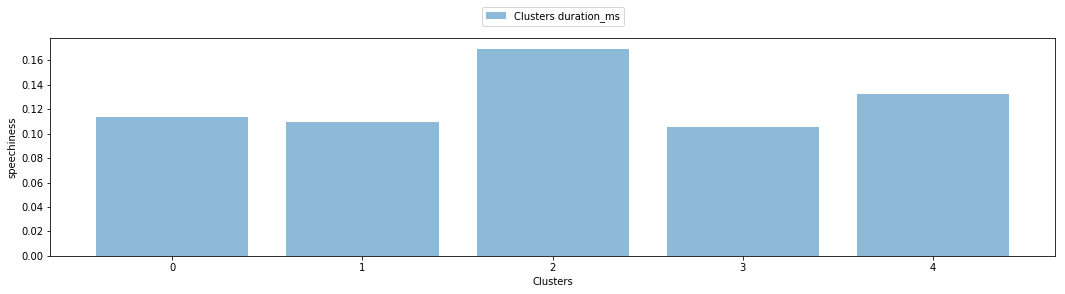

In [75]:
plt.figure(figsize=(18,4))
y = [Cluster1['speechiness'].mean(), Cluster2['speechiness'].mean(), Cluster3['speechiness'].mean(), Cluster4['speechiness'].mean(), Cluster5['speechiness'].mean()]
plt.bar(np.arange(5), y, alpha=0.5, label='Clusters duration_ms')
plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.1))
plt.ylabel('speechiness')
plt.xlabel('Clusters')
plt.show()